In [2]:
! git clone "https://github.com/soerenab/AudioMNIST.git"

Cloning into 'AudioMNIST'...
remote: Enumerating objects: 30119, done.
remote: Total 30119 (delta 0), reused 0 (delta 0), pack-reused 30119
Receiving objects: 100% (30119/30119), 944.54 MiB | 20.57 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Checking out files: 100% (30018/30018), done.


In [3]:
import torch as th
import torchaudio
import matplotlib.pyplot as plt
import librosa.display
import librosa
import numpy as np

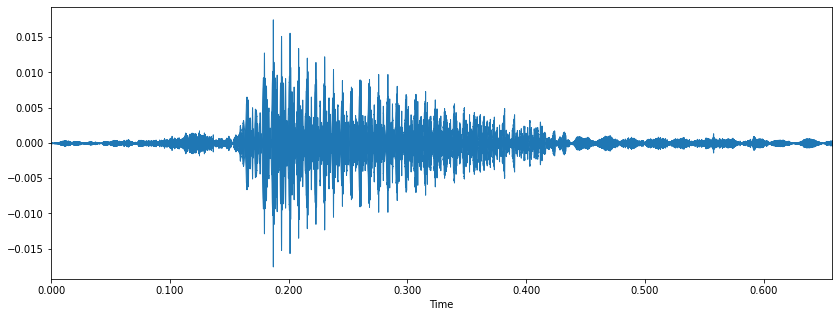

In [4]:
audio_path = "/content/AudioMNIST/data/{0}/{1}_{0}_{2}.wav".format("02", 5, 4)
data, sr = librosa.load(audio_path)

plt.figure(figsize = (14, 5))
librosa.display.waveplot(data, sr=sr)


In [5]:
def normalize(data):
  index = slice(4000,10000,6)
  normalized_data = data[index]
  normalized_data = abs(normalized_data/np.linalg.norm(normalized_data))
  return normalized_data*2

def extract(max_feature_lenght):
  dataset = []
  labels = []
  digits = [0,1,2,3,4,5,6,7,8,9]
  sample_index = list(range(50))
  filenames = []
  for i in list(range(max_feature_lenght)):
    i = i+1
    if i < 10:
      tmp = "0"+str(i)
      filenames.append(tmp)
    else:
      filenames.append(str(i))

  for digit in digits:
    for index in sample_index:
      tmp_data = []
      for filename in filenames:
        audio_path = "/content/AudioMNIST/data/{0}/{1}_{0}_{2}.wav".format(filename, digit, index)
        data, sr = librosa.load(audio_path)
        normalized_data = normalize(data)
        normalized_data = normalized_data.tolist()
        tmp_data.append(normalized_data)
      dataset.append(tmp_data)
      labels.append(digit)
  return dataset, labels

dataset, labels = extract(60)
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

In [6]:
class Encoder(th.nn.Module):
    def __init__(self, in_dim, output_dim, max_, N=250, lay=2):
        super(Encoder, self).__init__()
        self.N = N
        self.max_len = max_
        self.lstm = th.nn.LSTM(in_dim, N, lay, bidirectional=True, batch_first=True)
        self.output = th.nn.Linear(2 * N, output_dim)
        self.flatten = th.nn.Flatten()
    
        
    def forward(self, inputs):
        outputs, (hn, cn) = self.lstm(inputs)
        outputs = outputs[:, -1, :]
        #outputs = outputs.contiguous().view(-1, self.N)
        #outputs = self.flatten(outputs)
        outputs = self.output(outputs)
        return outputs

In [7]:
class Decoder(th.nn.Module):
    def __init__(self, in_dim, output_dim, max_, N=250, lay=2):
        super(Decoder, self).__init__()
        self.N = N
        self.max_len = max_
        self.lstm = th.nn.LSTM(in_dim, N, lay, bidirectional=True, batch_first=True)
        self.output = th.nn.Linear(2 * N, output_dim)
        self.flatten = th.nn.Flatten()
        
    def forward(self, inputs):
        outputs, (hn, cn) = self.lstm(inputs)
        #outputs = self.flatten(outputs)
        #outputs = outputs.contiguous().view(-1, self.N)
        outputs = outputs[:, -1, :]
        outputs = self.output(outputs)
        return outputs

In [8]:
class Joint(th.nn.Module):
    def __init__(self, input_size, output_size):
        super(Joint, self).__init__()
        self.linear = th.nn.Linear(input_size, output_size)
        
    def forward(self, enc, dec):
        inputs = th.cat((enc, dec), dim=1)
        #print("joint", inputs.shape)
        outputs = self.linear(inputs)
        return outputs

In [9]:
class TRANS_3L_250H(th.nn.Module):
    def __init__(self, features, num_classes, max_seq_len):
        super(TRANS_3L_250H, self).__init__()
        self.encoder = Encoder(features, num_classes, max_seq_len)
        self.decoder = Decoder(features, num_classes, max_seq_len)
        self.joint = Joint(2 * num_classes, num_classes)
        self.feat = features
        
    def forward(self, inputs, targets):
        encs = self.encoder(inputs)
        decs = self.decoder(targets)
        return self.joint(encs, decs)
        
        
    def pred(self, inputs):
        encs = self.encoder(inputs)
        zeros = th.zeros(len(inputs), 1, self.feat)
        decs = self.decoder(zeros)
        logit = self.joint(encs, decs)
        probs = th.nn.functional.softmax(logit, dim=1)
        pred = th.argmax(probs, dim=1)
        return pred

In [10]:
def train_epoch(model, lossfn, optimizer, trainloader):
    ls = 0
    counter = 0
    for seqs, labels in trainloader:
        seqs, labels = seqs.to(device), labels.to(device)
        outputs = model(seqs, seqs)
        loss = lossfn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ls += loss.detach().numpy()
        counter += 1
    return ls/counter

In [ ]:
'''cuda = th.cuda.is_available()  
device = th.device('cpu')
print(device)'''

In [ ]:
import random

numer_of_classes = 10
max_sequence_length = 60
feature_dims = 1000

model = TRANS_3L_250H(feature_dims, numer_of_classes, max_sequence_length)
epochs = 10
batch_size = 30

train_set = []
test_set = []

samples = list(range(500))
chosen_data_indexes = random.sample(range(0,500),batch_size)
for i in chosen_data_indexes:
  train_set.append(dataset[i])
  test_set.append(int(i/50))

In [53]:
# Training loss
opt = th.optim.AdamW(model.parameters(), lr=0.001)
l = th.nn.CrossEntropyLoss()
loss = []
for i in range(epochs):
    loss.append(train_epoch(model, l, opt, [[train_set, test_set]]))
    with th.no_grad():
        for param in model.parameters():
            param.add_(th.randn(param.size()) * 0.01)
    print(i, loss[-1])

0 2.3018383979797363
1 2.221306562423706
2 2.1694629192352295
3 2.0958831310272217
4 2.0012624263763428
5 1.931147813796997
6 1.7712582349777222
7 1.6008142232894897
8 1.5230120420455933
9 1.323448896408081
